In [14]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.6.10
Number of GPUs Available: 0


In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
import keras
import random
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from datetime import datetime

from mask_to_submission import masks_to_submission
import util

## Install the following packages
import imageio
from PIL import Image
import cv2
import natsort

Using TensorFlow backend.


## Constants

In [3]:
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
STEPS_PER_EPOCH = 2000
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Images

In [4]:
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/"

files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)
files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)
files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)
n = len(files_image)
n_test = len(files_test) 

# Load list of numpy arrays of training images and labels
print("Loading " + str(n) + " training images")
training_image_list = []
training_label_list = []
for i in range(n):
    print("Loading training image {:04d}\r".format(i)),
    training_image_list.append(imageio.imread(training_image_dir + files_image[i]))
    training_label_list.append(imageio.imread(training_label_dir + files_label[i]))

# Load list of numpy arrays of test images
print("Loading " + str(n_test) + " test images")
test_image_list = [imageio.imread(test_image_dir + files_test[i]) for i in range(n_test)]

print("TRAINING:")
print(training_image_list[0].shape)
print(training_label_list[0].shape)
print("TEST:")
print(test_image_list[0].shape)

Loading 100 training images
Loading training image 0000
Loading training image 0001
Loading training image 0002
Loading training image 0003
Loading training image 0004
Loading training image 0005
Loading training image 0006
Loading training image 0007
Loading training image 0008
Loading training image 0009
Loading training image 0010
Loading training image 0011
Loading training image 0012
Loading training image 0013
Loading training image 0014
Loading training image 0015
Loading training image 0016
Loading training image 0017
Loading training image 0018
Loading training image 0019
Loading training image 0020
Loading training image 0021
Loading training image 0022
Loading training image 0023
Loading training image 0024
Loading training image 0025
Loading training image 0026
Loading training image 0027
Loading training image 0028
Loading training image 0029
Loading training image 0030
Loading training image 0031
Loading training image 0032
Loading training image 0033
Loading training ima

## Padd Images
Training images have size 400x400 and test images have size 608x608. So we need to pad training images to same size, 
for that I use mirror padding for now.

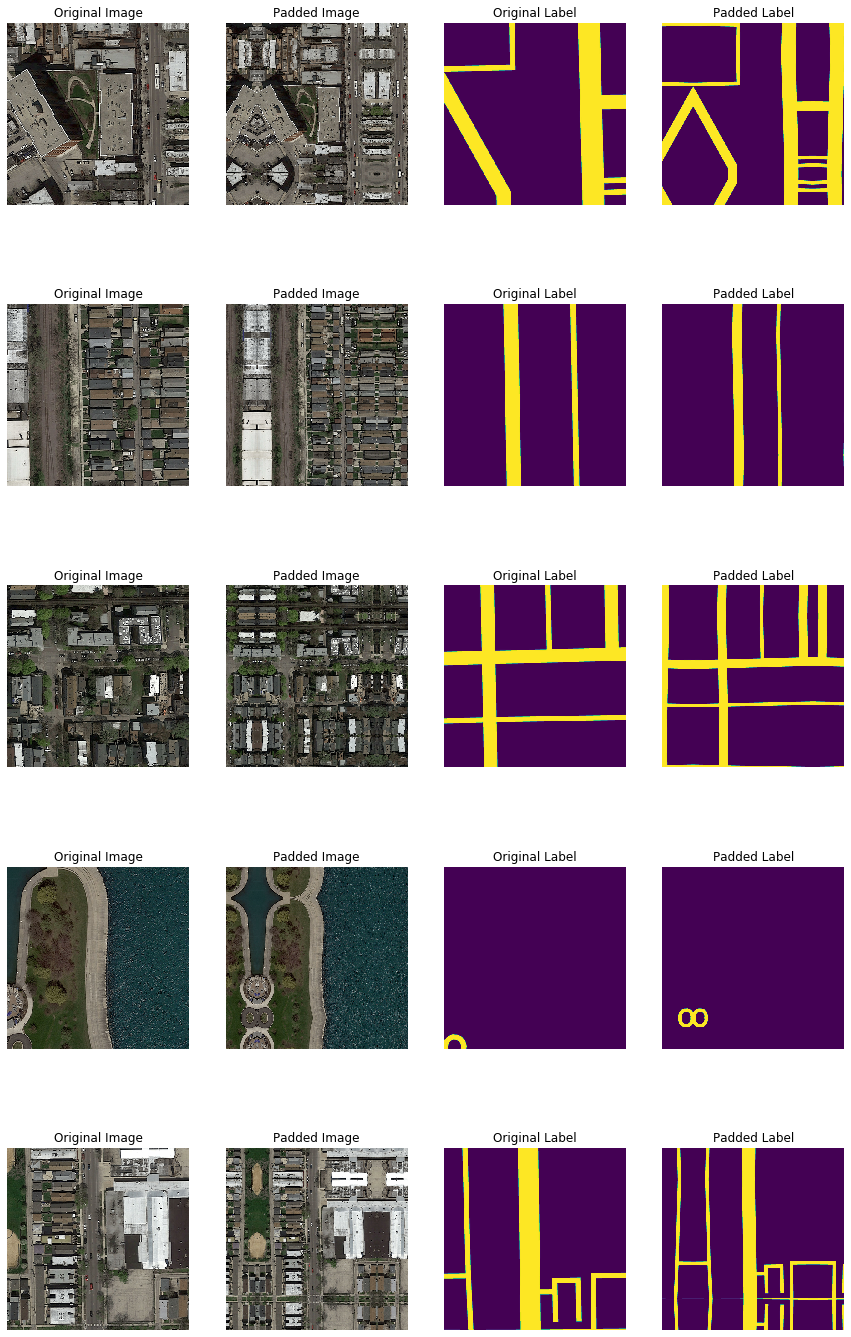

(100, 608, 608, 3)
(100, 608, 608, 1)


In [5]:
# Mirror padd all training images to get same size as test images
training_image_padded_list = [cv2.copyMakeBorder(training_image_list[i],104,104,104,104,cv2.BORDER_REFLECT) for i in range(n)]
training_label_padded_list = [cv2.copyMakeBorder(training_label_list[i],104,104,104,104,cv2.BORDER_REFLECT) for i in range(n)]

# Plot random Sample of images
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 4, i)
  plt.imshow(training_image_list[index])
  plt.title("Original Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(training_image_padded_list[index])
  plt.title("Padded Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(training_label_list[index]))
  plt.title("Original Label")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(training_label_padded_list[index]))
  plt.title("Padded Label")
  plt.axis('off')

plt.show()

# Convert image lists to numpy arrays for further processing
training_image = np.array(training_image_padded_list)
training_label = np.expand_dims(np.array(training_label_padded_list), -1)
test_image = np.array(test_image_list)
print(training_image.shape)
print(training_label.shape)

In [7]:
# Make sure label masks only have values 1 or zero
#thresh_val = 0.5
#training_label = (training_label > thresh_val).astype(np.uint8)
training_label = training_label/255
training_label = training_label.astype(np.float32)
#print(np.unique(training_label, return_counts=True, axis=None))
print(training_label.dtype)

float32


## Augment Training Data

We use the Keras Data Generator to augment our training data online while training. This is necessary because of memory consumption.

In [8]:
# We create an instance for the training images, training labels and test images
data_gen_args = dict(rotation_range=360,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.05,
                     shear_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='wrap')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow(
    training_image,
    batch_size=BATCH_SIZE,
    save_to_dir="training_images_augmented/images/",
    save_prefix="",
    save_format="png",
    seed=seed)
mask_generator = mask_datagen.flow(
    training_label,
    batch_size=BATCH_SIZE,
    save_to_dir="training_images_augmented/groundtruth/",
    save_prefix="",
    save_format="png",
    seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss :
    - Dice Coef Loss (https://arxiv.org/pdf/1606.04797v1.pdf)
    - Soft Dice Loss (Measure of interleaving of prediction image and label image)
    - Jaccard Distance

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [9]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def soft_dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-soft_dice_coef(y_true, y_pred)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## Model: Fully CNN built in Keras

In [10]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization() (conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = BatchNormalization() (conv2)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization() (conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = BatchNormalization() (conv3)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization() (conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = BatchNormalization() (conv4)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization() (conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = BatchNormalization() (conv5)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization() (conv5)
drop5 = Dropout(0.5)(conv5)

up6    = Conv2DTranspose(512, (2, 2), strides=(2, 2), activation = 'relu', padding='same')(drop5)
merge6 = concatenate([drop4,up6], axis = 3)
conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6  = BatchNormalization() (conv6)
conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6  = BatchNormalization() (conv6)

up7    = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation = 'relu', padding='same')(conv6)
merge7 = concatenate([conv3,up7], axis = 3)
conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7  = BatchNormalization() (conv7)
conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7  = BatchNormalization() (conv7)

up8    = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation = 'relu', padding='same')(conv7)
merge8 = concatenate([conv2,up8], axis = 3)
conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8  = BatchNormalization() (conv8)
conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8  = BatchNormalization() (conv8)

up9    = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation = 'relu', padding='same')(conv8)
merge9 = concatenate([conv1,up9], axis = 3)
conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9  = BatchNormalization() (conv9)
conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9  = BatchNormalization() (conv9)
conv9  = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9  = BatchNormalization() (conv9)

outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 608, 608, 64) 36928       batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Callbacks for Observations

In [11]:
#tbc=TensorBoardColab()
model_path = "./Models/fullyCNN_temp.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/fullyCNN_log.csv", separator=',', append=False)
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=6,
                               verbose=1,
                               epsilon=1e-4)

C:\Users\jzfri\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Model Training

In [12]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=jaccard_distance,
      metrics=[iou_coef])

In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks = [checkpointer, csv_logger, lr_reducer])

Epoch 1/100
   5/2000 [..............................] - ETA: 19:07:31 - loss: 0.2038 - iou_coef: 0.0010  

KeyboardInterrupt: 

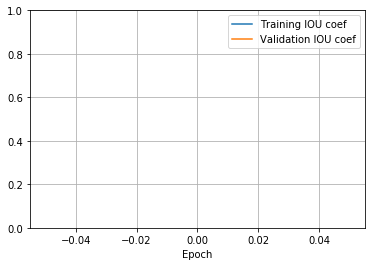

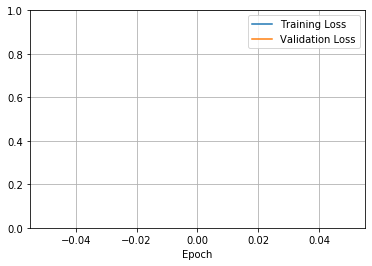

In [13]:
# Show a training report
training_info = pd.read_csv('./Logs/fullyCNN_log.csv', header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)

plt.show()

## Model Evaluation

In [ ]:
model = load_model("./Models/fullyCNN_temp.h5", custom_objects={'jaccard_distance': jaccard_distance, 'iou_coef': iou_coef})
#model.evaluate(test_images, test_label)
predictions = model.predict(test_image, verbose=1)

In [ ]:
thresh_val = 0.5
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File
Multiply image by 255 and convert to unit8 before storing s.t. it gets read out correctly by mask_to_submission!

In [ ]:
predictions = np.squeeze(predictions*255)
predictions = predictions.astype(np.uint8)
result_dir = './Results/Prediction_Images/fullyCNN_baseline/'

#print(predictions.shape)
#[print(predictions[i].shape) for i in range(n_test)]

[imageio.imwrite(result_dir + files_test[i], predictions[i],) for i in range(n_test)]
files_predictions = os.listdir(result_dir)
files_predictions = [result_dir + files_predictions[i] for i in range(n_test)]
masks_to_submission('./Results/Submissions/fullyCNN_baseline_19_April.csv', *files_predictions)
print('Submission ready')